In [1]:
import os

import h5py
import numpy as np
from skimage import io, transform, exposure, morphology, measure
import matplotlib.pyplot as plt

import core

def adjust_stack(array, dtype, align):
    adjusted = np.zeros(array.shape, dtype=dtype)
    for i in range(array.shape[0]):
        slc = array[i]
        slc_adjusted = align.apply(slc, out='array')
        adjusted[i] = slc_adjusted
    return adjusted
        

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [17]:
h5_path = "D:/Research/CoNi_16/Data/3D/new/CoNi16_test.dream3d"
h5 = h5py.File(h5_path, "r+")
cell_s = "DataContainers/ImageDataContainer/CellData"
ci = h5[cell_s]["CI"][:,:,:,0]

solutionFile = "D:/Research/scripts/Alignment/Slice420_CoNi16/TPS_Mapping.npy"
referencePoints = "D:/Research/scripts/Alignment/Slice420_CoNi16/ctr_pts_bse.txt"
distortedPoints = "D:/Research/scripts/Alignment/Slice420_CoNi16/ctr_pts_ebsd.txt"
referenceImage = "D:/Research/scripts/Alignment/Slice420_CoNi16/bse.tif"
align = core.Alignment(referencePoints, distortedPoints)
align.import_solution(solutionFile, referenceImage)

In [3]:
bse_slice_x = slice(476, 2696)
bse_slice_y = slice(175, 1840)
bse_folder = "D:/Research/CoNi_16/Data/3D/BSE/aligned/"
paths = sorted([path for path in os.listdir(bse_folder) if ".tif" in path], key=lambda x: int(x.replace("aligned_", "").replace(".tif","")))
bse_imgs_raw = np.array([io.imread(bse_folder+path, as_gray=True) for path in paths])
# Correct dtype and aspect ratio
bse_slice_x = slice(476, 2696)
bse_slice_y = slice(175, 1840)
bse_imgs_raw = np.float32(bse_imgs_raw)
bse_imgs = bse_imgs_raw[:, bse_slice_y, bse_slice_x]

In [4]:
# Transform to correct size
bse_stack = []
for i in range(bse_imgs.shape[0]):
    out = transform.resize(bse_imgs[i], ci[0].shape, anti_aliasing=False)
    bse_stack.append(out)
bse_stack = np.array(bse_stack)[::-1]

(460, 483, 644, 1) (460, 483, 644)
('BSE', dtype('<f4'))
('CI', dtype('<f4'))
('EulerAngles', dtype('<f4'))
('IQH', dtype('<f4'))
('IQS', dtype('<f4'))
('Mask', dtype('uint8'))
('Phases', dtype('int32'))
('SEM', dtype('uint8'))
('XC', dtype('<f4'))
('Z', dtype('<f4'))


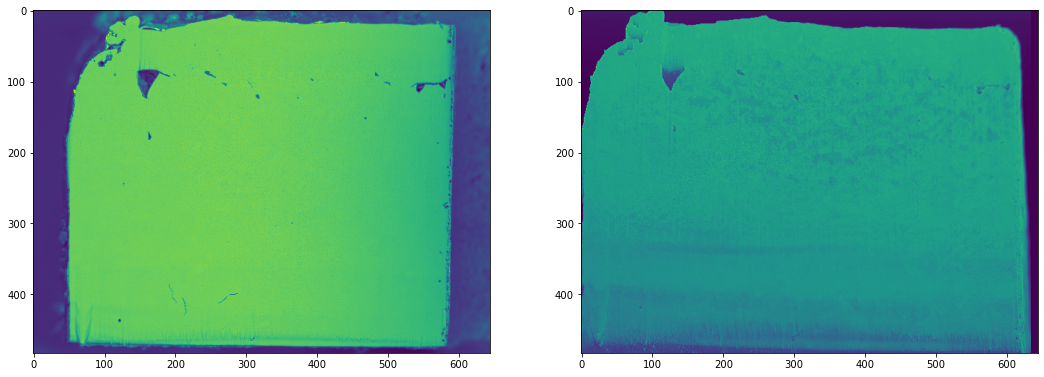

In [13]:
print(h5[cell_s]["CI"].shape, bse_stack.shape)
types = [(x, h5[cell_s][x].dtype) for x in h5[cell_s].keys()]
print(*types, sep='\n')
fig = plt.figure(figsize=(18,15))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(bse_stack[0])
ax2.imshow(h5[cell_s]["SEM"][0])
plt.show()

In [14]:
ci = np.array(h5.get(cell_s+"/CI"))
ci = adjust_stack(ci[:,:,:,0], np.float32, align).reshape(ci.shape)
h5[cell_s]["CI"][...] = ci
print("CI finished")
 
ea = np.array(h5.get(cell_s+"/EulerAngles"))
ea1 = np.copy(ea[:,:,:,0])
ea2 = np.copy(ea[:,:,:,1])
ea3 = np.copy(ea[:,:,:,2])
ea1 = adjust_stack(ea1, np.float32, align)
ea2 = adjust_stack(ea2, np.float32, align)
ea3 = adjust_stack(ea3, np.float32, align)
ea[:,:,:,0] = ea1
ea[:,:,:,1] = ea2
ea[:,:,:,2] = ea3
h5[cell_s]["EulerAngles"][...] = ea
print("Euler Angles finished")
 
iqh = np.array(h5.get(cell_s+"/IQH"))
iqh = adjust_stack(iqh[:,:,:,0], np.float32, align).reshape(iqh.shape)
h5[cell_s]["IQH"][...] = iqh
print("IQH finished")
 
iqs = np.array(h5.get(cell_s+"/IQS"))
iqs = adjust_stack(iqs[:,:,:,0], np.float32, align).reshape(iqs.shape)
h5[cell_s]["IQS"][...] = iqs
print("IQS finished")
 
mask = np.array(h5.get(cell_s+"/Mask"))
mask = adjust_stack(iqs[:,:,:,0], np.uint8, align).reshape(mask.shape)
h5[cell_s]["Mask"][...] = mask
print("Mask finished")

sem = np.array(h5.get(cell_s+"/SEM"))
sem = adjust_stack(sem[:,:,:,0], np.uint8, align).reshape(sem.shape)
h5[cell_s]["SEM"][...] = sem
print("SEM finished")

phase = np.array(h5.get(cell_s+"/Phases"))
phase = adjust_stack(phase[:,:,:,0], np.float32, align).reshape(phase.shape)
h5[cell_s]["Phases"][...] = phase
print("Phases finished")

xc = np.array(h5.get(cell_s+"/XC"))
xc = adjust_stack(xc[:,:,:,0], np.float32, align).reshape(xc.shape)
h5[cell_s]["XC"][...] = xc
print("XC finished")
 
z = np.array(h5.get(cell_s+"/Z"))
z = adjust_stack(z[:,:,:,0], np.float32, align).reshape(xc.shape)
h5[cell_s]["Z"][...] = z
print("Z finished")

CI finished
Euler Angles finished
IQH finished
IQS finished
Mask finished
SEM finished
Phases finished
XC finished
Z finished


In [19]:
h5.close()

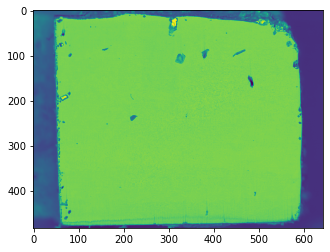

In [18]:
h5[cell_s]["BSE"][...] = bse_stack.reshape(*bse_stack.shape, 1)[:,:,::-1]

plt.imshow(h5[cell_s]["BSE"][420,:,:,0])
#plt.imshow(np.around(bse_stack[420]*255/bse_stack.max(), 0).astype(np.uint8))
plt.show()